# Neural problems via GENOT (advanced)

This example shows an advanced neural problems usage, e.g., the {class}`~moscot.problems.time.GENOTLinProblem`.

In [6]:
%load_ext autoreload
%autoreload 2
from moscot.problems import GENOTLinProblem
from moscot import datasets
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from anndata import AnnData
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data Setup

First we set up some data from 3 different normal distributions

/var/folders/k9/9wc7lvwj2g34_r74kn6cr0nr0000gn/T/ipykernel_58791/2178879371.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(adata[adata.obs['batch'] == i].obsm['normal'].T[0], adata[adata.obs['batch'] == i].obsm['normal'].T[1], c=list(mcolors.BASE_COLORS.values())[i])


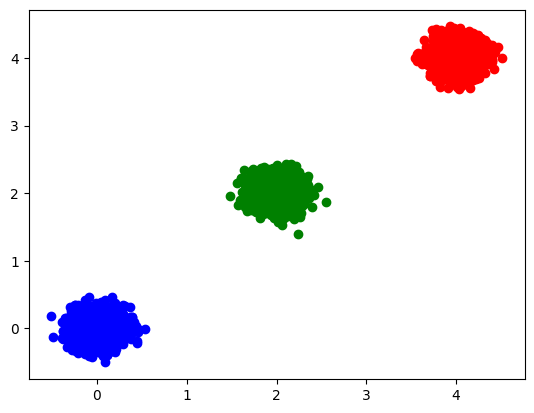

In [9]:
batches = []
n_batches = 3
n_obs_per_batch = 2048
for i in range(n_batches):
    batches += [i] * n_obs_per_batch
adata = AnnData(
    obsm = { 'normal': np.vstack([np.random.multivariate_normal([i * 2, i * 2], [[.02,0],[0,.02]], n_obs_per_batch) for i in range(n_batches)]) },
    obs = { 'batch': batches }
)

for i in range(n_batches):
    plt.scatter(adata[adata.obs['batch'] == i].obsm['normal'].T[0], adata[adata.obs['batch'] == i].obsm['normal'].T[1], c=list(mcolors.BASE_COLORS.values())[i])

### Problem Setup

Next, we set up a problem with a policy mapping 0 to both 1 and 2, and then train this problem _jointly_!

In [31]:
problem = GENOTLinProblem(adata)
problem = problem.prepare(policy="explicit", subset=[(0, 1), (0, 2)], key="batch", joint_attr="normal", conditional_attr={"attr": "obs", "key": "batch"})
problem = problem.solve(batch_size=128,iterations=20000, train_size=1.0,  velocity_field_hidden_dims=[512, 512, 512],velocity_field_time_dims=[1024, 1024, 1024], velocity_field_output_dims=[1024, 1024, 1024])

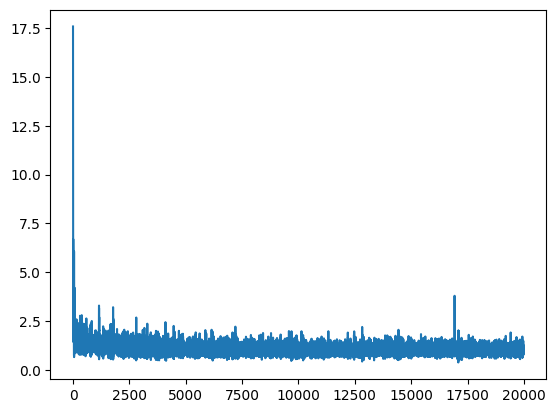

In [32]:
plt.plot(problem.solution.logs['loss'])

### Results

Finally, we can visualize the results and see that the source indeed maps to both targets rather cleanly.

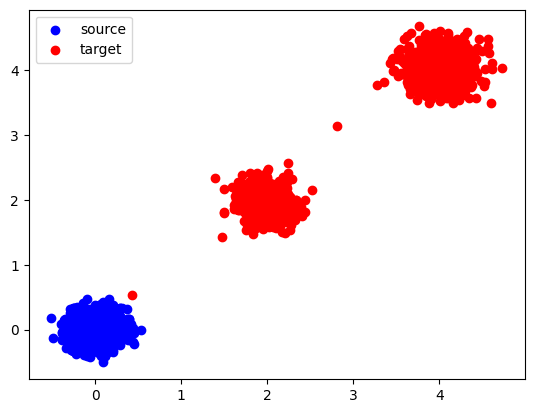

In [33]:
adata_subset = adata[adata.obs['batch'] == 0, :]
pushed = problem.solution.push(adata_subset.obsm['normal'], adata_subset.obs['batch'].values.reshape(adata_subset.shape[0], -1))
plt.scatter(adata[~adata.obs['batch'].astype('bool')].obsm['normal'].T[0], adata[~adata.obs['batch'].astype('bool')].obsm['normal'].T[1], c="b", label="source")
plt.scatter(pushed.T[0], pushed.T[1], c='r', label="target")
plt.legend()